In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

rmse = lambda x, y: math.sqrt(mean_squared_error(x, y))

def alternating_least_squares(data, mask, num_factors=10, regularization=0.1, num_iterations=20):
    num_users, num_items = data.shape
    U = np.random.rand(num_users, num_factors)
    V = np.random.rand(num_items, num_factors)

    for iteration in range(num_iterations):
        # Update item factors V
        B = U.T @ (data * mask)
        Q = np.array([U[row, :][:, np.newaxis] @ U[row, :][np.newaxis, :] for row in range(num_users)])
        
        for col in range(num_items):
            sum_r1_mat = np.sum(Q[mask[:, col] == 1], axis=0)
            V[col, :] = np.linalg.solve(sum_r1_mat + regularization * np.eye(num_factors), B[:, col])

        # Update user factors U
        B = V.T @ (data.T * mask.T)
        Q = np.array([V[row, :][:, np.newaxis] @ V[row, :][np.newaxis, :] for row in range(num_items)])

        for row in range(num_users):
            sum_r1_mat = np.sum(Q[mask[row, :] == 1], axis=0)
            U[row, :] = np.linalg.solve(sum_r1_mat + regularization * np.eye(num_factors), B[:, row])

        # Compute reconstruction error
        reconstructed_matrix = U @ V.T
        error = rmse(data[mask == 1], reconstructed_matrix[mask == 1])
        print(f"Iteration {iteration + 1}/{num_iterations}, RMSE: {error:.4f}")

    return U, V



In [38]:
# # Call pre-proc to get data

from load import load_data
train_pd, test_pd = load_data()

# from preprocess import preprocess
# A_tilde, standardized_train_ratings, train_users, train_items, means, stds, val_users, val_items, orig_val_ratings, standardized_val_ratings, submission_users, submission_items = preprocess((train_df, submission_df))

# Use provided setup instead
def extract_users_items_predictions(data_pd):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data_pd.Prediction.values
    return users, movies, predictions

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)
test_users, test_movies, test_predictions = extract_users_items_predictions(test_pd)

# also create full matrix of observed values
data = np.full((10000, 1000), np.mean(train_predictions))
mask = np.zeros((10000, 1000)) # 0 -> unobserved value, 1->observed value


over = 0
under = 0
for user, movie, pred in zip(train_users, train_movies, train_predictions):
    if pred > 5:
        over += 1
    if pred < 1:
        under += 1
    data[user - 1][movie - 1] = pred
    mask[user - 1][movie - 1] = 1

# test our predictions with the true values
def get_score(predictions, target_values=test_predictions):
    return rmse(predictions, target_values)

def extract_prediction_from_full_matrix(reconstructed_matrix, users=test_users, movies=test_movies):
    # returns predictions for the users-movies combinations specified based on a full m \times n matrix
    assert(len(users) == len(movies)), "users-movies combinations specified should have equal length"
    predictions = np.zeros(len(test_users))

    for i, (user, movie) in enumerate(zip(users, movies)):
        predictions[i] = reconstructed_matrix[user][movie]

    return predictions


In [32]:
print(train_predictions.shape, train_predictions)

(1176952,) [4 3 4 ... 3 4 3]


In [28]:
# Standardize the training data
mean_rating = np.mean(train_predictions)
std_rating = np.std(train_predictions)
standardized_data = (data - mean_rating) / std_rating

print(f"mean: {mean_rating}")
print(f"std_rating: {std_rating}")

print(f"mean of std data: {np.mean(standardized_data)}")
print(f"std of std data: {np.std(standardized_data)}")

print(f"std data shape: {standardized_data.shape}")
print(standardized_data)
print(mask)

mean: 3.8572805008190647
std_rating: 1.1190567337624968
mean of std data: 1.5077361581461446e-17
std of std data: 0.3430673403283966
std data shape: (10000, 1000)
[[ 0.          0.         -0.76607421 ... -0.76607421 -0.76607421
   0.        ]
 [ 0.          0.         -1.65968395 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          1.02114528 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.76607421
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[0. 0. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:

# Run ALS
num_factors = 20
regularization = 1
num_iterations = 50

# Run ALS on standardized data
U, V = alternating_least_squares(standardized_data, mask, num_factors, regularization, num_iterations)



Iteration 1/50, RMSE: 0.8542
Iteration 2/50, RMSE: 0.7897
Iteration 3/50, RMSE: 0.7687
Iteration 4/50, RMSE: 0.7581
Iteration 5/50, RMSE: 0.7516
Iteration 6/50, RMSE: 0.7473
Iteration 7/50, RMSE: 0.7442
Iteration 8/50, RMSE: 0.7419
Iteration 9/50, RMSE: 0.7402
Iteration 10/50, RMSE: 0.7388
Iteration 11/50, RMSE: 0.7377
Iteration 12/50, RMSE: 0.7368
Iteration 13/50, RMSE: 0.7361
Iteration 14/50, RMSE: 0.7355
Iteration 15/50, RMSE: 0.7349
Iteration 16/50, RMSE: 0.7345
Iteration 17/50, RMSE: 0.7341
Iteration 18/50, RMSE: 0.7337
Iteration 19/50, RMSE: 0.7334
Iteration 20/50, RMSE: 0.7331
Iteration 21/50, RMSE: 0.7328
Iteration 22/50, RMSE: 0.7326
Iteration 23/50, RMSE: 0.7324
Iteration 24/50, RMSE: 0.7322
Iteration 25/50, RMSE: 0.7320
Iteration 26/50, RMSE: 0.7318
Iteration 27/50, RMSE: 0.7317
Iteration 28/50, RMSE: 0.7315
Iteration 29/50, RMSE: 0.7314
Iteration 30/50, RMSE: 0.7313
Iteration 31/50, RMSE: 0.7312
Iteration 32/50, RMSE: 0.7311
Iteration 33/50, RMSE: 0.7310
Iteration 34/50, RM

In [19]:
# De-standardize the predictions
reconstructed_standardized_matrix = np.dot(U, V.T)
reconstructed_matrix = (reconstructed_standardized_matrix * std_rating) + mean_rating

predictions = extract_prediction_from_full_matrix(reconstructed_matrix, test_users, test_movies)

# Evaluate RMSE on test set
final_rmse = get_score(predictions)
print(f"Final RMSE on test set: {final_rmse:.4f}")

Final RMSE on test set: 1.0765


In [34]:
print(reconstructed_matrix.max())

13.749875505151852


In [35]:
# Clip at 1 and 5

# check min and max of predictions_rounded
print("min:", predictions.min().item())
print("max:", predictions.max().item())
print("mean:", predictions.mean().item())

# Count the number of values under 1 and over 5
count_under_1 = (predictions < 1).sum().item()
count_over_5 = (predictions > 5).sum().item()
print("count_over_5:", count_over_5)
print("count_under_1:", count_under_1)

# Clip the values to be within the range [1, 5]
predictions = np.clip(predictions, 1, 5)

min: 1.0
max: 5.0
mean: 3.5723241892496285
count_over_5: 0
count_under_1: 0


min: 1.0
max: 5.0
mean: 3.5723241892496285


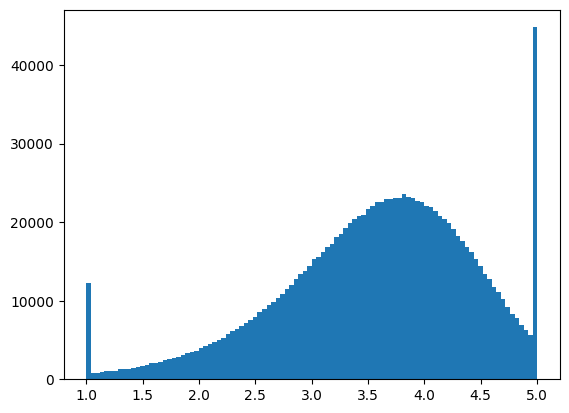

In [36]:
# check min and max of predictions
print("min:", predictions.min().item())
print("max:", predictions.max().item())
print("mean:", predictions.mean().item())

# check distribution of predictions
plt.hist(predictions.flatten(), bins=100)
plt.show()

In [6]:
# save submission
def to_submission_format(users, movies, predictions):
    return pd.DataFrame(data={'Id': ['r{}_c{}'.format(user + 1, movie + 1) for user, movie in zip(users, movies)],
                              'Prediction': predictions})

submission = to_submission_format(test_users, test_movies, predictions)

submission.to_csv('../data/submission_data/submission.csv', index=False)